# <center> STA663 Final Project: Scalable K-means
### <center> Xin Xu, Fu Wen

## <center> Abstract 

Due to its simplicity, the k-means algorithm is one of the most famous machine learning algorithms used to cluster data[1]. The main critical problem of this algorithm is that it might be blocked locally based on the initial random chosen centers. The k-means++ algorithm is developed to solve this problem, spreading out the initial centers with an updating non-uniform distribution. However, K-means++ has a limited applicability to large data sets due to its inherent sequential nature, which requires k passes through the whole data set to find the optimal initialization of centers. The K-means|| algorithm in the paper "Scalable K-Means++" is the parallel version of the k-means++[2] and an improvement. Instead of sampling a single point, it oversamples a couple of centers in each iteration and guarantees the performance at the same time. In this report, we firstly implemented the K-means|| algorithm in Python. Then, we parallelized the algorithm in Spark and applied it to the GAUSSMIXTURE dataset simulated as in [1] and the SPAM dataset from UC Irvine Machine Learning repository [3]. In the end, we compared the clustering cost and convergence speed with the k-means|| algorithm to the result of the k-means and the k-means++.

## 1. Introduction

### 1.1 Background and Related Algorithm

As one of the most popular clustering algorithms, the **k-means** algorithm has been widely used for the last half of the century[4]. The main idea is to randomly choose k centers, repeatedly assign each point to its nearest center and calculate the new centers by minimizing the sum of the squares of the distance in its neighborhood.

The k-means algorithm has a critical problem of unreliable initialization[2]. This algorithm with an incorrect initialization cannot find a globally optimal solution but rests on a locally optimal solution. In addition, the running time before convergence is long. **K-means++** algorithm avoids this problem by finding k better initial centers. It first samples one random point uniformly from the data, then sets the subsequent k-1 centers with probability proportional to its contribution to the overall error given the previous centers. In contrast to the k-means algorithm, k-means++ reduces the probability of picking several initial centers in one cluster. However, the sequence initialization process also limits its applicability to large data sets or data with large k since the whole algorithm is not scalable.

Bahmani et al. constructed the scalable k-means++ algorithm (**k-means||** algorithm) in their paper "Scalable K-Means++"[1]. The main idea is to sample more than one point (O(k)) in each round and repeat the process for fewer iterations (O(logn)). Then, the algorithm reclusters the O(klogn) points generated from the above process into k initial centers.



### 1.2 Notation and the Algorithm

Suppose $X = \{x_1, \dots, x_n \}$ are d-dimentional points to be clustered and k is the number of cluster (a positer integer). 

For a subset $Y \in X$, define the distance from a point $x$ to $Y$ as $d(x,Y) = min_{y \in Y} \| x-y\|$, where $\|x -y \|$denote the Euclidean distance between $x$ and $y$, define the centroid of $Y$ as
$$Centroid(Y) = \frac{1}{|Y|} \sum_{y \in Y} y$$

For a set of cluster centers $C = \{ c_1, c_2 ,\dots , c_k\}$, define the _cost of $Y$_ with respect to $C$ as:

$$ \phi_Y(C) = \sum_{y \in Y} d(y,C)^2$$

In k-means|| algorithm, it set an oversampling factor $l = \Omega (k)$. $l>1$ is an integer.

1. Sample a point uniformaly from X as the first center $C$
2. Compute the cost of clustering based on this choice $\phi_{X}(C)=\psi$
3. for $O(log\psi)$ times repeat:  
a. Independently sample $l$ points with probability $p_{x}=\frac{l\cdot d^{2}(x,C)}{\phi_{X}(C)}$ as $C'$
b. $C=C\cup C'$
4. For each point $x \in C$, compute $w_{x}$ as the number of points in $X$ closer to x than other point in $C$
5. Get k clusters from reclustering those weighted points in $C$ 

## 2.  Implementation

### 2.1 K-Means 

In [1]:
%%file distance_func.py
import numpy as np

def distance(data, centroids):
    """ Calculate the distance from each data point to each center
    Parameters:
       data   n*d
       center k*d
    
    Returns:
       distence n*k 
    """
    ## calculate distence between each point to the centroids
    dist = np.sum((data[:, np.newaxis, :] - centroids)**2, axis=2)
    return dist

Overwriting distance_func.py


In [2]:
%%file kmeans_func.py
import numpy as np
from distance_func import distance

def KMeans(data, k, centroids, max_iter = 10000): 
    
    """ Apply the KMeans clustering algorithm
    
    Parameters:
      data                        ndarrays data 
      k                           number of cluster
      centroids                   initial centroids
    
    Returns:
      "Iteration before Coverge"  time used to converge
      "Centroids"                 the final centroids finded by KMeans    
      "Labels"                    the cluster of each data   
    """
    
    n = data.shape[0] 
    iterations = 0
    
    while iterations < max_iter:        
        dist = distance(data,centroids)
        
        ## give cluster label to each point 
        cluster_label = np.argmin(dist, axis=1)
        
        ## calculate new centroids
        newCentroids = np.zeros(centroids.shape)
        for j in range(0, k):
            if sum(cluster_label == j) == 0:
                newCentroids[j] = centroids[j]
            else:
                newCentroids[j] = np.mean(data[cluster_label == j, :], axis=0)
        
        ## Check if it is converged
        if np.array_equal(centroids, newCentroids):
            print("Converge")
            break 
            
        centroids = newCentroids
        iterations += 1
        
    return({"Iteration before Coverge": iterations, 
            "Centroids": centroids, 
            "Labels": cluster_label})

Overwriting kmeans_func.py


### 2.2.2 K-Means++

In [3]:
%%file kmeanspp_func.py
import numpy as np
from distance_func import distance

def cost(dist):
    """ Calculate the cost of data with respect to the current centroids
    Parameters:
       dist     distance matrix between data and current centroids
    
    Returns:    the normalized constant in the distribution 
    """
    return np.sum(np.min(dist,axis=1))

def distribution(dist,cost):
    """ Calculate the distribution to sample new centers
    Parameters:
       dist       distance matrix between data and current centroids
       cost       the cost of data with respect to the current centroids
    Returns:      distribution 
    """
    return np.min(dist, axis=1)/cost

def sample_new(data,distribution,l):
    """ Sample new centers
    
    Parameters:
       data         n*d
       distribution n*1
       l            the number of new centers to sample
    Returns:        new centers                          
    """
    return data[np.random.choice(range(len(distribution)),l,p=distribution),:]

def KMeansPlusPlus(data, k):    
    """ Apply the KMeans++ clustering algorithm to get the initial centroids   
    Parameters: 
      data                        ndarrays data 
      k                           number of cluster
    
    Returns:
      "Centroids"                 the complete initial centroids by KMeans++
      
    """
    
    #Initialize the first centroid
    centroids = data[np.random.choice(data.shape[0],1),:]
    
    while centroids.shape[0] < k :
                
        #Get the distance between data and centroids
        dist = distance(data, centroids)
        
        #Calculate the cost of data with respect to the centroids
        norm_const = cost(dist)
        
        #Calculate the distribution for sampling a new center
        p = distribution(dist,norm_const)
        
        #Sample the new center and append it to the original ones
        centroids = np.r_[centroids, sample_new(data,p,1)]
    
    return centroids

Overwriting kmeanspp_func.py


### 2.2.3 Kmeans Parallel

In [44]:
%%file scalablekmeanspp_func.py
import numpy as np
from distance_func import distance
from kmeanspp_func import cost, distribution, sample_new

def get_weight(dist,centroids):
    min_dist = np.zeros(dist.shape)
    min_dist[range(dist.shape[0]), np.argmin(dist, axis=1)] = 1
    count = np.array([np.count_nonzero(min_dist[:, i]) for i in range(centroids.shape[0])])
    return count/np.sum(count)

def weightedKMeans(data, k, weight, centroids, max_iter = 10000): 
    
    """ Apply the weighted KMeans clustering algorithm
    
    Parameters:
      data                        ndarrays data 
      k                           number of cluster
      weight                      weight matrix of data
      centroids                   initial centroids
    
    Returns:
      "Iteration before Coverge"  time used to converge
      "Centroids"                 the final centroids finded by KMeans    
      "Labels"                    the cluster of each data   
    """
    
    n = data.shape[0] 
    iterations = 0
    
    while iterations < max_iter:        
        dist = distance(data, centroids) * weight[:, np.newaxis]
        
        ## give cluster label to each point 
        cluster_label = np.argmin(dist, axis=1)
        
        ## calculate new centroids
        newCentroids = np.zeros(centroids.shape)
        for j in range(0, k):
            if sum(cluster_label == j) == 0:
                newCentroids[j] = centroids[j]
            else:
                newCentroids[j] = np.mean(data[cluster_label == j, :], axis=0)
        
        ## Check if it is converged
        if np.array_equal(centroids, newCentroids):
            print("Converge")
            break 
            
        centroids = newCentroids
        iterations += 1
        
    return({"Iteration before Coverge": iterations, 
            "Centroids": centroids, 
            "Labels": cluster_label})

def ScalableKMeansPlusPlus(data, k, l,iter=5):
    
    """ Apply the KMeans|| clustering algorithm
    
    Parameters:
      data     ndarrays data 
      k        number of cluster
      l        number of point sampled in each iteration
    
    Returns:   the final centroids finded by KMeans||  
      
    """
    
    centroids = data[np.random.choice(range(data.shape[0]),1), :]
    
    
    for i in range(iter):
        #Get the distance between data and centroids
        dist = distance(data, centroids)
        
        #Calculate the cost of data with respect to the centroids
        norm_const = cost(dist)
        
        
        #Calculate the distribution for sampling l new centers
        p = distribution(dist,norm_const)
        
        #Sample the l new centers and append them to the original ones
        centroids = np.r_[centroids, sample_new(data,p,l)]
    

    ## reduce k*l to k using KMeans++ 
    dist = distance(data, centroids)
    weights = get_weight(dist, centroids)
    initial = centroids[np.random.choice(range(len(weights)),k,replace=False,p=weights),:]
    return weightedKMeans(centroids, k, weights, initial)

Overwriting scalablekmeanspp_func.py


In [148]:
# from kmeanspp_func import KMeansPlusPlus
# from scalablekmeanspp_func import ScalableKMeansPlusPlus
# l = 10
# initial_Kpp = KMeansPlusPlus(data,k)
# initial_Kll = ScalableKMeansPlusPlus(data,k,l)['Centroids']

Converge


## 3. Testing

In [7]:
%%file test_distance.py

import numpy as np
from numpy.testing import assert_almost_equal
from distance_func import distance

def test_non_negativity():
    u = np.random.normal(size=(3,4))
    v = np.random.normal(size=(5,4))
    assert (distance(u, v)>= 0).all()
    
def test_coincidence_when_zero():
    u = np.zeros((3,4))
    v = np.zeros((5,4))
    assert (distance(u, v)==0).all()

def test_coincidence_when_not_zero():
    u = np.random.normal(size=(3,4))
    v = np.random.normal(size=(5,4))
    assert (distance(u, v)!= 0).any()

def test_symmetry():
    u = np.random.normal(size=(3,4))
    v = np.random.normal(size=(5,4))
    assert (distance(u, v)== distance(v, u).T).all()

def test_known1():
    u = np.array([[0,0],[1,1]])
    v = np.array([[0,0],[1,1]])
    dist = np.array([[0,2],[2,0]])
    assert_almost_equal(distance(u, v), dist)
    
def test_known2():
    u = np.array([[0,0,0],[1,1,1],[2,2,2]])
    v = np.array([[1,1,1],[2,2,2],[3,3,3]])
    dist = np.array([[3,12,27],[0,3,12],[3,0,3]])
    assert_almost_equal(distance(u, v), dist)

Writing test_distance.py


In [8]:
%%file test_cost.py

import numpy as np
from numpy.testing import assert_almost_equal
from kmeanspp_func import cost
from distance_func import distance

def test_non_negative():
    for i in range(10):
        data = np.random.normal(size=(5,4))
        c = data[np.random.choice(range(4),2),]
        dist = distance(data,c)
        assert cost(dist) >= 0


Writing test_cost.py


In [9]:
%%file test_distribution.py

import numpy as np
from numpy.testing import assert_almost_equal
from distance_func import distance
from kmeanspp_func import distribution,cost

def test_non_negative():
    data = np.random.normal(size=(20,4))
    centroids = data[np.random.choice(range(4),4),]
    dist = distance(data,centroids)
    c = cost(dist)
    p = distribution(dist,c)
    assert (p>=0).all()
    
def test_sum_to_one():
    data = np.random.normal(size=(20,4))
    centroids = data[np.random.choice(range(4),4),]
    dist = distance(data,centroids)
    c = cost(dist)
    p = distribution(dist,c)
    assert_almost_equal(np.sum(p),1)

Writing test_distribution.py


In [10]:
%%file test_sample_new.py
import numpy as np
from numpy.testing import assert_almost_equal
from distance_func import distance
from kmeanspp_func import cost, sample_new, distribution

def test_length():
    data = np.random.normal(size=(20,4))
    centroids = data[np.random.choice(range(4),4),]
    dist = distance(data,centroids)
    c = cost(dist)
    p = distribution(dist,c)
    l = 5
    c_new = sample_new(data,p,l)
    assert len(c_new)==5

def test_in_data():
    data = np.random.normal(size=(20,4))
    centroids = data[np.random.choice(range(4),4),]
    dist = distance(data,centroids)
    c = cost(dist)
    p = distribution(dist,c)
    l = 5
    c_new = sample_new(data,p,l)
    check = [i in data for i in c_new]
    assert all(check)
    

Writing test_sample_new.py


In [11]:
%%file test_weights.py

import numpy as np
from numpy.testing import assert_almost_equal
from distance_func import distance
from scalablekmeanspp_func import get_weight

def test_non_negative():
    data = np.random.normal(size=(20,4))
    centroids = data[np.random.choice(range(4),4),]
    dist = distance(data,centroids)
    w = get_weight(dist,centroids)
    assert (w>=0).all()
    
def test_sum_to_one():
    data = np.random.normal(size=(20,4))
    centroids = data[np.random.choice(range(4),4),]
    dist = distance(data,centroids)
    w = get_weight(dist,centroids)
    assert_almost_equal(np.sum(w),1)

Writing test_weights.py


In [12]:
%%file test_kmeans.py
import numpy as np
from distance_func import distance
from kmeans_func import KMeans

def test_label():
    for i in range(10):
        data = np.random.normal(size=(50,2))
        k = 3
        centroids = data[np.random.choice(range(data.shape[0]), k, replace=False),:]
        label = KMeans(data, k, centroids)["Labels"]
        assert max(label) == k-1 and len(label)==data.shape[0]

Writing test_kmeans.py


In [15]:
%%file test_kmeanspp.py
import numpy as np
from kmeanspp_func import KMeansPlusPlus
from scalablekmeanspp_func import ScalableKMeansPlusPlus

def test_length():
    data = np.random.normal(size=(2000,2))
    k = 3
    l = 5
    ini1 = KMeansPlusPlus(data, k)
    ini2 = ScalableKMeansPlusPlus(data, k, l)
    assert len(ini1)==k and len(ini2)==k

def test_length():
    data = np.random.normal(size=(2000,2))
    k = 3
    l = 5
    ini1 = KMeansPlusPlus(data, k)
    ini2 = ScalableKMeansPlusPlus(data, k, l)
    check1 = [i in data for i in ini1]
    check2 = [i in data for i in ini1]
    assert all(check1) and all(check2)

Overwriting test_kmeanspp.py


In [10]:
! py.test 

============================= test session starts ==============================
platform darwin -- Python 3.5.1, pytest-2.8.1, py-1.4.30, pluggy-0.3.1
rootdir: /Users/fwen/Desktop/sta-663-2016/STA663-Final-Project, inifile: 
collected 15 items 

test_cost.py .
test_distance.py ......
test_distribution.py ..
test_kmeans.py .
test_kmeanspp.py .
test_sample_new.py ..
test_weights.py ..

========================== 15 passed in 0.24 seconds ===========================


## 4.  Optimization

In [12]:
%load_ext Cython

In [14]:
%%cython -a
import numpy as np
cimport numpy as np

def distance_cy(data, centroids):
    """ Calculate the distance from each data point to each center
    Parameters:
       data   n*d
       center k*d
    
    Returns:
       distence n*k 
    """
    ## calculate distence between each point to the centroids
    dist = np.sum((data[:, np.newaxis, :] - centroids)**2, axis=2)
    return dist
def KMeans_cy(data, k, centroids, max_iter = 10000): 
    
    """ Apply the KMeans clustering algorithm
    
    Parameters:
      data                        ndarrays data 
      k                           number of cluster
      centroids                   initial centroids
    
    Returns:
      "Iteration before Coverge"  time used to converge
      "Centroids"                 the final centroids finded by KMeans    
      "Labels"                    the cluster of each data   
    """
    
    n = data.shape[0] 
    iterations = 0
    
    while iterations < max_iter:        
        dist = distance_cy(data,centroids)
        
        ## give cluster label to each point 
        cluster_label = np.argmin(dist, axis=1)
        
        ## calculate new centroids
        newCentroids = np.zeros(centroids.shape)
        for j in range(0, k):
            if sum(cluster_label == j) == 0:
                newCentroids[j] = centroids[j]
            else:
                newCentroids[j] = np.mean(data[cluster_label == j, :], axis=0)
        
        ## Check if it is converged
        if np.array_equal(centroids, newCentroids):
            print("Converge")
            break 
            
        centroids = newCentroids
        iterations += 1
        
    return({"Iteration before Coverge": iterations, 
            "Centroids": centroids, 
            "Labels": cluster_label})

def cost_cy(dist):
    """ Calculate the cost of data with respect to the current centroids
    Parameters:
       dist     distance matrix between data and current centroids
    
    Returns:    the normalized constant in the distribution 
    """
    return np.sum(np.min(dist,axis=1))

def distribution_cy(dist,cost):
    """ Calculate the distribution to sample new centers
    Parameters:
       dist       distance matrix between data and current centroids
       cost       the cost of data with respect to the current centroids
    Returns:      distribution 
    """
    return np.min(dist, axis=1)/cost

def sample_new_cy(data,distribution,l):
    """ Sample new centers
    
    Parameters:
       data         n*d
       distribution n*1
       l            the number of new centers to sample
    Returns:        new centers                          
    """
    return data[np.random.choice(range(len(distribution)),l,p=distribution),:]

def KMeansPlusPlus_cy(data, k):    
    """ Apply the KMeans++ clustering algorithm to get the initial centroids   
    Parameters: 
      data                        ndarrays data 
      k                           number of cluster
    
    Returns:
      "Centroids"                 the complete initial centroids by KMeans++
      
    """
    
    #Initialize the first centroid
    centroids = data[np.random.choice(data.shape[0],1),:]
    
    while centroids.shape[0] < k :
                
        #Get the distance between data and centroids
        dist = distance_cy(data, centroids)
        
        #Calculate the cost of data with respect to the centroids
        norm_const = cost_cy(dist)
        
        #Calculate the distribution for sampling a new center
        p = distribution_cy(dist,norm_const)
        
        #Sample the new center and append it to the original ones
        centroids = np.r_[centroids, sample_new_cy(data,p,1)]
    
    return centroids

def get_weight_cy(dist,centroids):
    min_dist = np.zeros(dist.shape)
    min_dist[range(dist.shape[0]), np.argmin(dist, axis=1)] = 1
    count = np.array([np.count_nonzero(min_dist[:, i]) for i in range(centroids.shape[0])])
    return count/np.sum(count)

def weightedKMeans_cy(data, k, weight, centroids, max_iter = 10000): 
    
    """ Apply the weighted KMeans clustering algorithm
    
    Parameters:
      data                        ndarrays data 
      k                           number of cluster
      weight                      weight matrix of data
      centroids                   initial centroids
    
    Returns:
      "Iteration before Coverge"  time used to converge
      "Centroids"                 the final centroids finded by KMeans    
      "Labels"                    the cluster of each data   
    """
    
    n = data.shape[0] 
    iterations = 0
    
    while iterations < max_iter:        
        dist = distance_cy(data, centroids) * weight[:, np.newaxis]
        
        ## give cluster label to each point 
        cluster_label = np.argmin(dist, axis=1)
        
        ## calculate new centroids
        newCentroids = np.zeros(centroids.shape)
        for j in range(0, k):
            if sum(cluster_label == j) == 0:
                newCentroids[j] = centroids[j]
            else:
                newCentroids[j] = np.mean(data[cluster_label == j, :], axis=0)
        
        ## Check if it is converged
        if np.array_equal(centroids, newCentroids):
            print("Converge")
            break 
            
        centroids = newCentroids
        iterations += 1
        
    return({"Iteration before Coverge": iterations, 
            "Centroids": centroids, 
            "Labels": cluster_label})

def ScalableKMeansPlusPlus_cy(data, k, l,iter=5):
    
    """ Apply the KMeans|| clustering algorithm
    
    Parameters:
      data     ndarrays data 
      k        number of cluster
      l        number of point sampled in each iteration
    
    Returns:   the final centroids finded by KMeans||  
      
    """
    
    centroids = data[np.random.choice(range(data.shape[0]),1), :]
    
    
    for i in range(iter):
        #Get the distance between data and centroids
        dist = distance_cy(data, centroids)
        
        #Calculate the cost of data with respect to the centroids
        norm_const = cost_cy(dist)
        
        #Calculate the distribution for sampling l new centers
        p = distribution_cy(dist,norm_const)
        
        #Sample the l new centers and append them to the original ones
        centroids = np.r_[centroids, sample_new_cy(data,p,l)]
    

    ## reduce k*l to k using KMeans++ 
    dist = distance_cy(data, centroids)
    weights = get_weight_cy(dist,centroids)
    initial = centroids[np.random.choice(range(len(weights)),k,replace=False,p=weights),:]
    return weightedKMeans_cy(centroids, k, weights, initial)

## 5. High performance computing

Use `multiprocessing`, we speed up `cost` function and `sample_new` function with all cpu cores. So, we parallelly calculate the distance from each point to its nearest center and its probability distribution for next sample in `cost` function. In `sample_new` function, we sample $l$ new centroids parallelly, which is the most meaningful part of `KMeans ||` algorithm.

In [77]:
%%cython -a

import numpy as np
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from multiprocessing import Pool, cpu_count
import multiprocessing as mp
from functools import partial
from distance_func import distance

def min_distance(d, centroids):
    
    """ Calculate the minimum distance from point d 
        to its nearest center in centroids."""
    dist = np.min(np.sum((centroids - d)**2, axis=1))
    return dist


# speed up by multiprocessing
def cost_p(data, centroids): 
    
    """ Calculate the cost of data with respect to 
    the current centroids and the new probability 
    distribution of each point for next sample"""    

    with Pool(processes = cpu_count()) as pool:
        partial_dist = partial(min_distance, centroids = centroids)
        min_dist = pool.map(partial_dist, data)
        cost = np.sum(min_dist)
        p = min_dist/cost
    return cost,p


def randomSample(x, a, p):
    np.random.seed()
    return np.random.choice(a = a, size = x , p =p)


## speed up with multiprocessing
def sample_new_p(data, distribution, l):
    
    """ Sample new centers"""  
    
    with Pool(processes = cpu_count()) as pool:
        partial_rc = partial(randomSample, a = len(distribution), p=distribution)
        index = pool.map(partial_rc,[1]*l)
    return np.squeeze(data[index,:],axis=(1,))


def min_distance_index_p(d, centroids):
    
    """ Return the index of the minimum distance from point d 
        to its nearest center in centroids."""
    
    minInd = np.argmin(np.sum((centroids - d)**2, axis=1))
    return minInd 

## speed up with multiprocessing
def get_weight_p(data, centroids):
    
    """ Return weight of all centroids """

    with Pool(processes = cpu_count()) as pool:
        partial_minInd = partial(min_distance_index_p, centroids = centroids )
        min_index = pool.map(partial_minInd, data)
        count = np.array([np.sum(np.array(min_index) == i) for i in range(centroids.shape[0])])
    return count/np.sum(count)

def weightedKMeans_p(data, k, weight, centroids, max_iter = 10000): 
    
    """ Apply the weighted KMeans clustering algorithm
    
    Parameters:
      data                        ndarrays data 
      k                           number of cluster
      weight                      weight matrix of data
      centroids                   initial centroids
    
    Returns:
      "Iteration before Coverge"  time used to converge
      "Centroids"                 the final centroids finded by KMeans    
      "Labels"                    the cluster of each data   
    """
    
    n = data.shape[0] 
    iterations = 0
    
    while iterations < max_iter:        
        dist = distance(data, centroids)*weight[:, np.newaxis]
        
        ## give cluster label to each point 
        cluster_label = np.argmin(dist, axis=1)
        
        ## calculate new centroids
        newCentroids = np.zeros(centroids.shape)
        for j in range(0, k):
            if sum(cluster_label == j) == 0:
                newCentroids[j] = centroids[j]
            else:
                newCentroids[j] = np.mean(data[cluster_label == j, :], axis=0)
        
        ## Check if it is converged
        if np.array_equal(centroids, newCentroids):
            print("Converge")
            break 
            
        centroids = newCentroids
        iterations += 1
        
    return({"Iteration before Coverge": iterations, 
            "Centroids": centroids, 
            "Labels": cluster_label})

def ScalableKMeansPlusPlus_p(data, k, l,iter=5):
    
    """ Apply the KMeans|| clustering algorithm"""
    
    centroids = data[np.random.choice(range(data.shape[0]),1), :]    
    
    for i in range(iter):   
        
        # Calculate the cost and new distribution
        norm_const = cost_p(data, centroids)[0]
        p = cost_p(data, centroids)[1] 
        
        # Sample the several(l) new centers and append them to the original ones
        centroids = np.r_[centroids, sample_new_p(data, p, l)]
        
    ## reduce k*l to k using KMeans++ 
    weights = get_weight_p(data,centroids)
    initial = centroids[np.random.choice(range(len(weights)),k,replace=False,p=weights),:]
    return weightedKMeans_p(centroids, k, weights, initial)

## 6.  Application and comparison
In this part, we test the two statements as in Bahmani's Paper[2]:

- `k-means||` obtains as a solution whose clustering cost is on par with `k-means++` and hence is expexcted to be much better than random.

- `k-means||` runs in a fewer number of rounds when compared to `k-means++`, which translates into a faster running time especially in the parallel implementation.

based on a simulated dataset and a real-world dataset. 

### 6.1 Simulate Data 

To generate the dataset GAUSSMIXTURE, we sampled k=5 centers from a 15-dimensional spherical Gaussian distribution with mean at the origin and variance $R\in \{1,10,100 \}$ and then added points from Gaussian distributions with unit variance around each center.

In [57]:
## Simulate data
k = 20
n = 10000
d = 15

## simulate k centers from 15-dimensional spherical Gaussian distribution 
mean = np.hstack(np.zeros((d,1)))
cov = np.diag(np.array([1,10,100]*5))
centers = np.random.multivariate_normal(mean, cov, k)

## Simulate n data
for i in range(k):
    mean = centers[i]
    if i == 0:
        data = np.random.multivariate_normal(mean, np.diag(np.ones(d)), int(n/k+n%k))
        trueLabels = np.repeat(i,int(n/k+n%k))
    else:
        data = np.append(data, np.random.multivariate_normal(mean, np.diag(np.ones(d)) , int(n/k)), axis = 0) 
        trueLabels = np.append(trueLabels,np.repeat(i,int(n/k)))

Visualizing the first 4 dimension dimension of data as following:

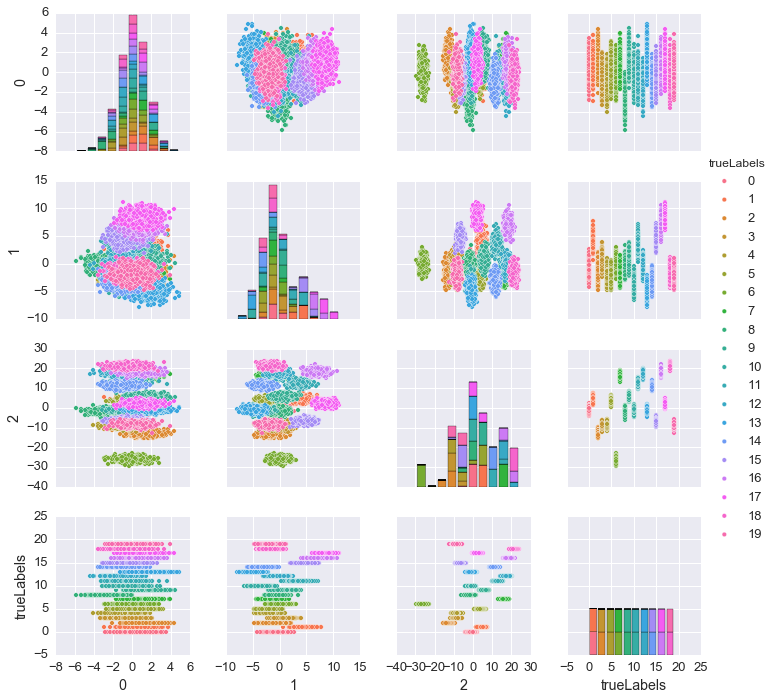

In [17]:
data_v = DataFrame(data[:,0:3]) 
data_v['trueLabels'] = trueLabels
import seaborn as sns
sns.set_context("notebook", font_scale=1.3)
sns.pairplot(data_v, hue="trueLabels")
pass

#### Implement K-means with Ramdom Initialization

In [58]:
from kmeans_func import KMeans
centroids_initial = data[np.random.choice(range(data.shape[0]), k, replace=False),:]
output_k = KMeans(data, k, centroids_initial)

Converge


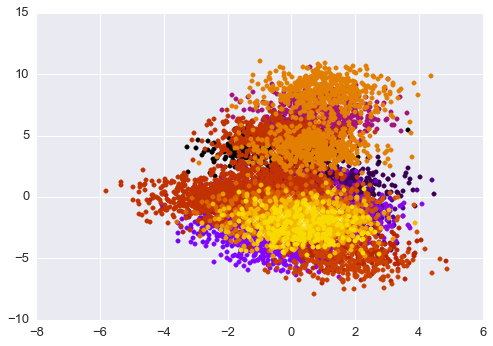

In [19]:
## plot the first two dimensions
centroids = data[np.random.choice(range(data.shape[0]), k, replace=False),:]

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, k)]

centroids1 =output_k["Centroids"]
labels1 = output_k["Labels"]

for i,color in enumerate(colors,start =1):
    plt.scatter(data[labels1==i, :][:,0], data[labels1==i, :][:,1], color=color)

for j in range(k):
    plt.scatter(centroids1[j,0],centroids1[j,1],color = 'w',marker='x')  

#### Implement KMeans with KMeans++ Intialization

In [59]:
from kmeans_func import KMeans
from kmeanspp_func import KMeansPlusPlus

centroids_initial = KMeansPlusPlus(data, 20)
output_kpp = KMeans(data, k, centroids_initial)

Converge


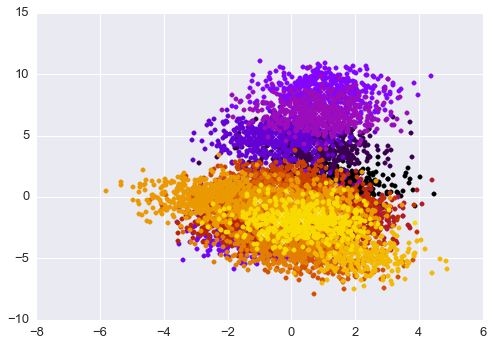

In [21]:
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, k)]

centroids1 =output_kpp["Centroids"]
labels1 = output_kpp["Labels"]

for i,color in enumerate(colors,start =1):
    plt.scatter(data[labels1==i, :][:,0], data[labels1==i, :][:,1], color=color)

for j in range(k):
    plt.scatter(centroids1[j,0],centroids1[j,1],color = 'w',marker='x') 

#### Implement KMeans with Scalable KMeans++ Intialization

In [60]:
from kmeans_func import KMeans
from scalablekmeanspp_func import ScalableKMeansPlusPlus
l = 10
centroids_initial = ScalableKMeansPlusPlus(data, 20, l)['Centroids']
output_spp = KMeans(data, k, centroids_initial)

Converge
Converge


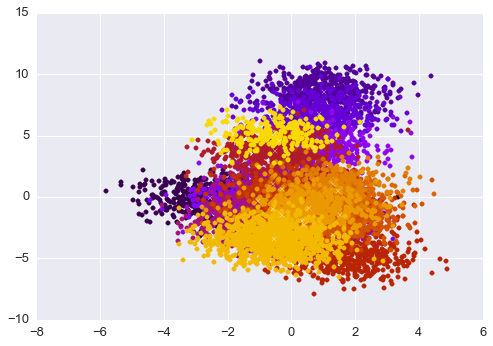

In [51]:
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, k)]

centroids1 =output_spp["Centroids"]
labels1 = output_spp["Labels"]

for i,color in enumerate(colors,start =1):
    plt.scatter(data[labels1==i, :][:,0], data[labels1==i, :][:,1], color=color)

for j in range(k):
    plt.scatter(centroids1[j,0],centroids1[j,1],color = 'w',marker='x')  

### Compare Misclassification Rate

In [25]:
def MisClassRate(trueLabels, predict):
    """
    Calculate the misclassification rate of the algorithm
    
    Parameters:
    trueLabels   n*1 true labels of each observation  
    predict      n*1 predict labels of each observation 
    
    Returns:     misclassification rate 
    """
    
    df = DataFrame({'True':trueLabels, 'Predict':predict['Labels'],'V':1})
    table = pd.pivot_table(df, values ='V', index = ['True'], columns=['Predict'], aggfunc=np.sum).fillna(0)
    misRate = 1-sum(table.max(axis=1))/n
    return misRate

In [61]:
print("Misclassification Rate:")
print("Random:", MisClassRate(trueLabels, output_k)) # Random 
print("KMeans++:",MisClassRate(trueLabels, output_kpp)) # KMeans++
print("Scalable KMeans++:", MisClassRate(trueLabels, output_spp)) # Scalable KMeans++

Misclassification Rate:
Random: 0.0932
KMeans++: 0.0447
Scalable KMeans++: 0.0551


### Compare Clustering Cost

In [53]:
from distance_func import distance
from kmeanspp_func import cost
def clusterCost(data,predict):
    dist = distance(data,predict["Centroids"])
    return cost(dist)/(10**4)

In [62]:
print("Clustering Cost:")
print("Random:", clusterCost(data,output_k)) # Random 
print("KMeans++:",clusterCost(data,output_kpp)) # KMeans++
print("Scalable KMeans++:", clusterCost(data,output_spp)) # Scalable KMeans++

Clustering Cost:
Random: 51.3460602623
KMeans++: 29.1853329529
Scalable KMeans++: 43.2697260077


### Compare runtime

In [29]:
%%time
a = KMeansPlusPlus(data, k)  # KMeans++ 
b = KMeans(data,k,a)

Converge
CPU times: user 7.35 s, sys: 506 ms, total: 7.86 s
Wall time: 8.02 s


In [75]:
%%time
a = ScalableKMeansPlusPlus(data, k, l)['Centroids'] # Scalable KMeans++
b = KMeans(data,k,a)

Converge
Converge
CPU times: user 4.47 s, sys: 272 ms, total: 4.74 s
Wall time: 4.86 s


In [73]:
%%time
a = ScalableKMeansPlusPlus_cy(data, k, l)['Centroids'] # Scalable KMeans++ with cython 
b = KMeans_cy(data,k,a)

Converge
Converge
CPU times: user 5.52 s, sys: 370 ms, total: 5.89 s
Wall time: 6.03 s


In [78]:
%%time
a = ScalableKMeansPlusPlus_p(data, k, l)['Centroids'] # Scalable KMeans++ with parallel
b = KMeans_cy(data,k,a)

Converge
Converge
CPU times: user 10.1 s, sys: 774 ms, total: 10.8 s
Wall time: 12.6 s


#### Spark

In [110]:
import warnings
warnings.filterwarnings('ignore')

In [106]:
from pyspark.mllib.clustering import KMeans
from pyspark import SparkContext
sc = sc = SparkContext('local[*]')

In [111]:
%%time
pdata =sc.parallelize(data)
data_model = KMeans.train(pdata, k, maxIterations=1000, runs=10, initializationMode="kmeans||")

CPU times: user 89.7 ms, sys: 18.5 ms, total: 108 ms
Wall time: 4.61 s


### 6.2 Real-World Data

In [63]:
f = open("spambase.data","r")
df = pd.read_table('spambase.data', sep=',', names=range(58))
df = np.array(df)

In [64]:
from kmeans_func import KMeans
from kmeanspp_func import KMeansPlusPlus
# from scalablekmeanspp_func import ScalableKMeansPlusPlus

# random
Rcentroids_initial = df[np.random.choice(range(df.shape[0]), k, replace=False),:]
Routput_k = KMeans_cy(df, k, Rcentroids_initial)

# KMeans++
Rcentroids_initial_kpp = KMeansPlusPlus_cy(df, 20)
Routput_kpp = KMeans_cy(df, k, Rcentroids_initial_kpp)

# Scalable KMeans++
Rcentroids_initial_spp = ScalableKMeansPlusPlus(df, 20, 10)['Centroids']
Routput_spp = KMeans_cy(df, k, Rcentroids_initial_spp)

Converge
Converge
Converge
Converge


In [65]:
Rcentroids_initial_spp2k = ScalableKMeansPlusPlus(df, 20, 40)['Centroids']
Routput_spp2k = KMeans_cy(df, k, Rcentroids_initial_spp2k)
print(Routput_spp2k['Iteration before Coverge'])

Converge
Converge
92


In [66]:
print("Clustering Cost:")
print("Random:", clusterCost(df,Routput_k)) # Random 
print("KMeans++:",clusterCost(df,Routput_kpp)) # KMeans++
print("Scalable KMeans++(l=2/k):", clusterCost(df,Routput_spp)) # Scalable KMeans++
print("Scalable KMeans++(l=2k):", clusterCost(df,Routput_spp2k)) # Scalable KMeans++

Clustering Cost:
Random: 15293.8932604
KMeans++: 2352.42485007
Scalable KMeans++(l=2/k): 7089.83080874
Scalable KMeans++(l=2k): 5955.85965768


In [79]:
%%time
k = 20
l = 10
a = KMeansPlusPlus(df, k)  # KMeans++ 
b = KMeans(df, k, a)

Converge
CPU times: user 4.42 s, sys: 854 ms, total: 5.27 s
Wall time: 5.46 s


In [80]:
%%time
a = ScalableKMeansPlusPlus(df, k, l)['Centroids'] # Scalable KMeans++
b = KMeans(df,k,a)

Converge
Converge
CPU times: user 2.53 s, sys: 562 ms, total: 3.09 s
Wall time: 3.21 s


In [81]:
%%time
a = ScalableKMeansPlusPlus_cy(df, k, l)['Centroids'] # Scalable KMeans++ with cython 
b = KMeans_cy(df,k,a)

Converge
Converge
CPU times: user 28.2 s, sys: 2.95 s, total: 31.2 s
Wall time: 31.6 s


In [82]:
%%time
a = ScalableKMeansPlusPlus_p(df, k, l)['Centroids'] # Scalable KMeans++ with parallel
b = KMeans_cy(df,k,a)

Converge
Converge
CPU times: user 9.23 s, sys: 1.27 s, total: 10.5 s
Wall time: 11.7 s


#### Spark

In [112]:
%%time
pdf =sc.parallelize(df)
df_model = KMeans.train(pdf, k, maxIterations=1000, runs=10, initializationMode="kmeans||")

CPU times: user 110 ms, sys: 37.3 ms, total: 147 ms
Wall time: 4.68 s


## Reference

[1] Wu, Xindong, et al. "Top 10 algorithms in data mining." Knowledge and information systems 14.1 (2008): 1-37.

[2] Bahmani, Bahman, et al. "Scalable k-means++." Proceedings of the VLDB Endowment 5.7 (2012): 622-633

[3] Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
